In [1]:
%run preamble.ipynb

In [2]:
ICIs = pd.read_hdf("data/singlefiwepoch14600_step496400.hdf5")

In [3]:
nCat = 5

In [4]:
fs = 32000

# Group by number of clicks

In [5]:
baseline = ICIs.iloc[0, 0]

In [6]:
ICIs = ICIs.loc[:, ICIs.columns > -1]

In [7]:
def groupbyClicks(el):
    if el is None:
        return None
    return {k: list(g) for k, g in it.groupby(sorted(el, key=len, reverse=True), len)}

In [8]:
groupedBaseline = groupbyClicks(baseline)

In [9]:
groupedICI = ICIs.applymap(groupbyClicks)

# ATE

## Mean ICI

In [10]:
def getMeanICI(el):
    if el is None:
        return None
    return {k: np.mean(np.diff(v)) for k, v in el.items()}

In [11]:
meanBaseline = getMeanICI(groupedBaseline)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
meanICIs = groupedICI.applymap(getMeanICI)

**With regards to -1**

<Figure size 1800x1200 with 0 Axes>

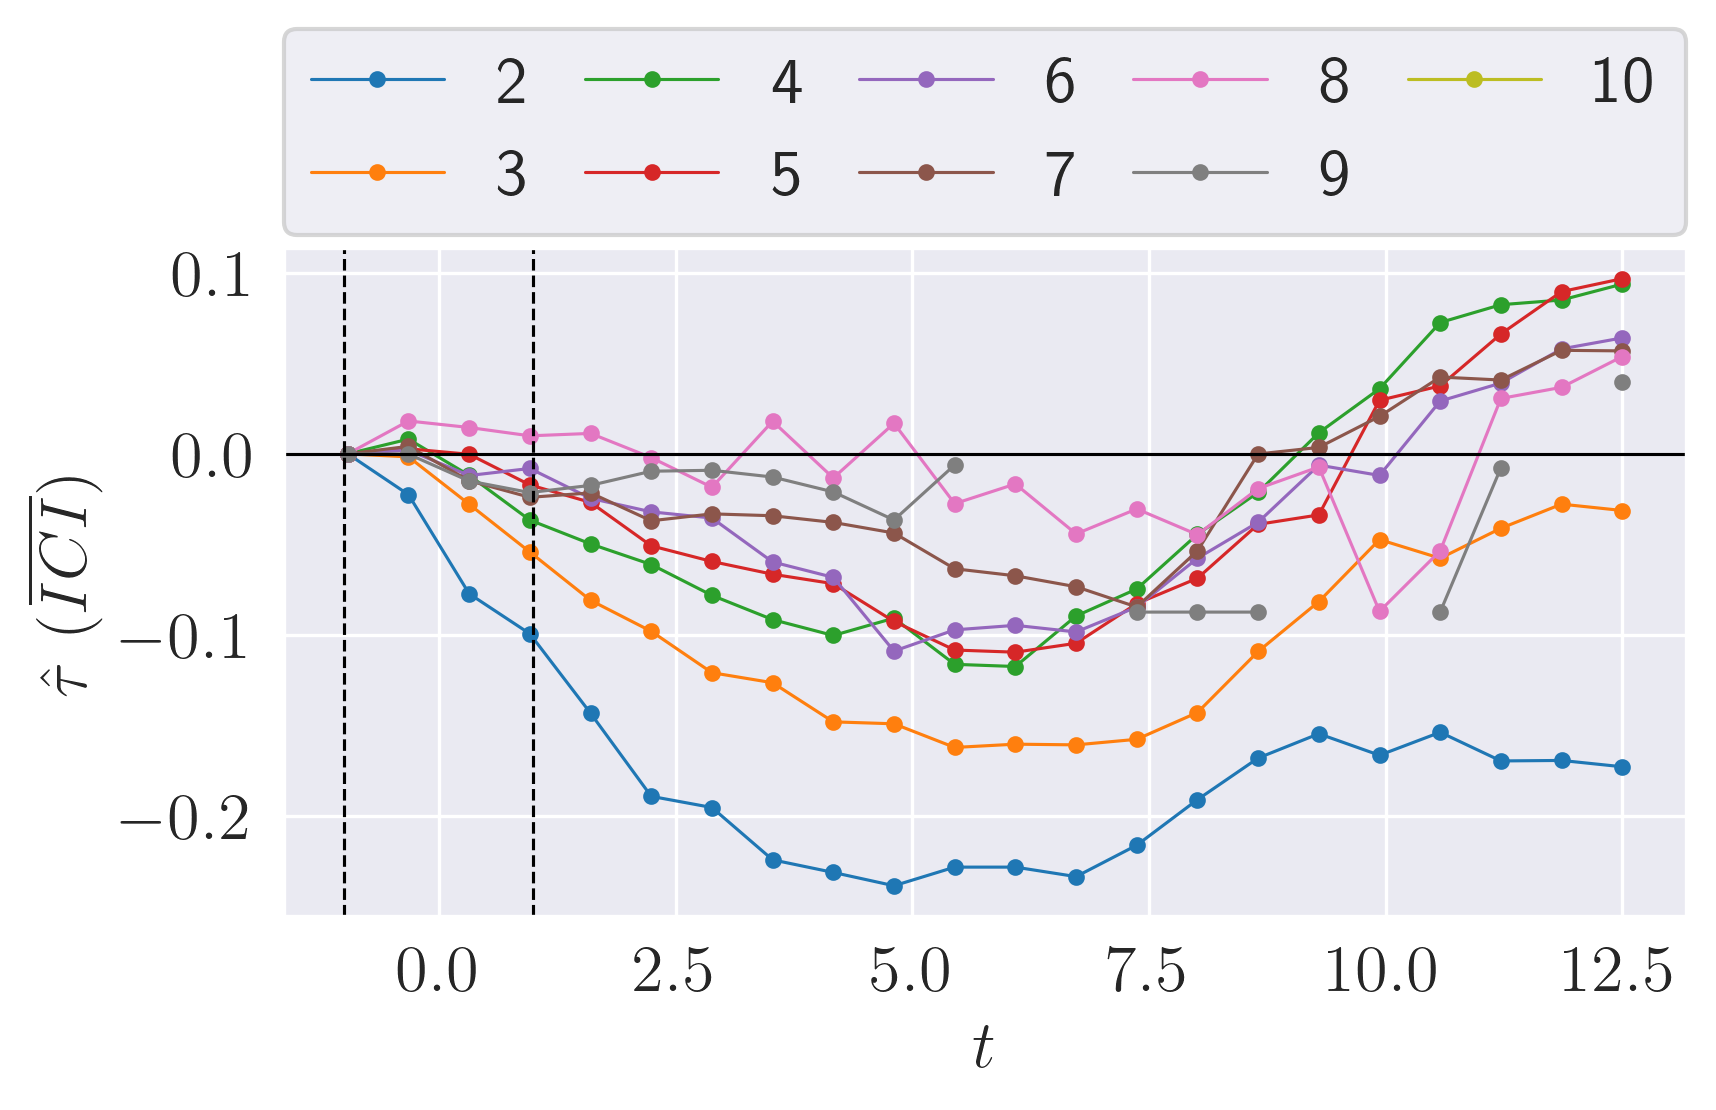

<Figure size 1800x1200 with 0 Axes>

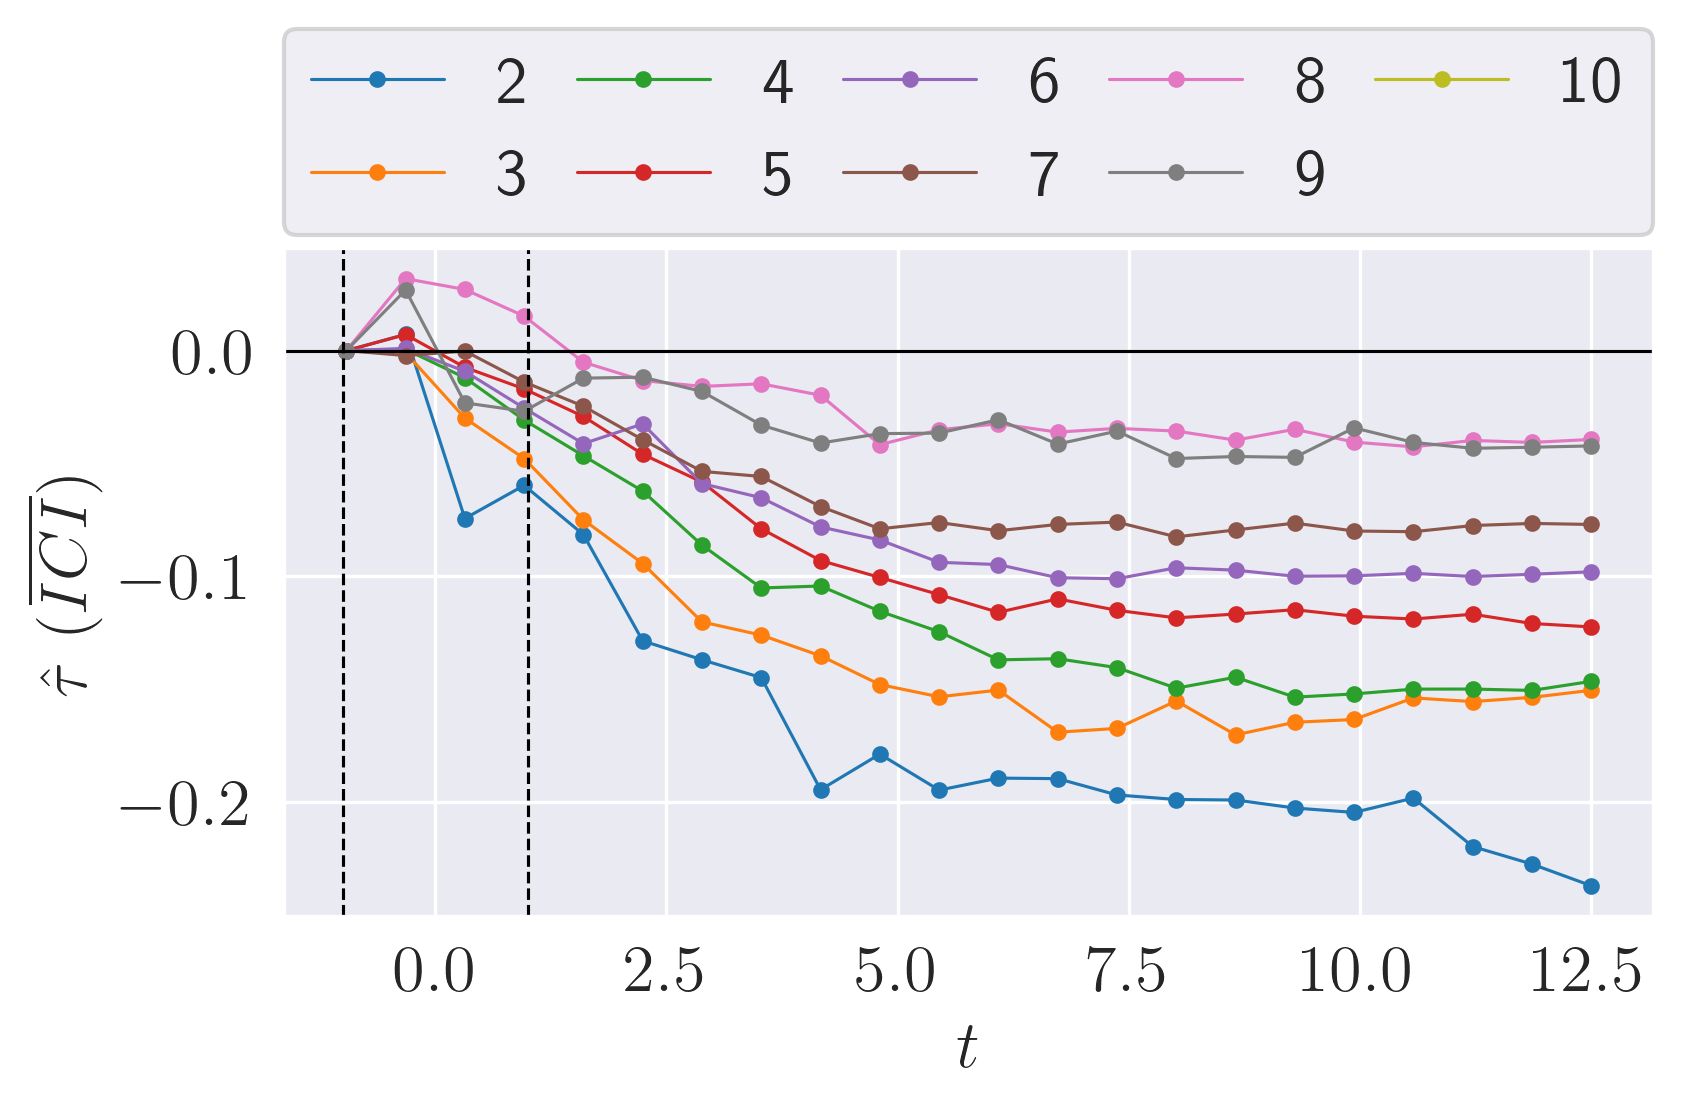

<Figure size 1800x1200 with 0 Axes>

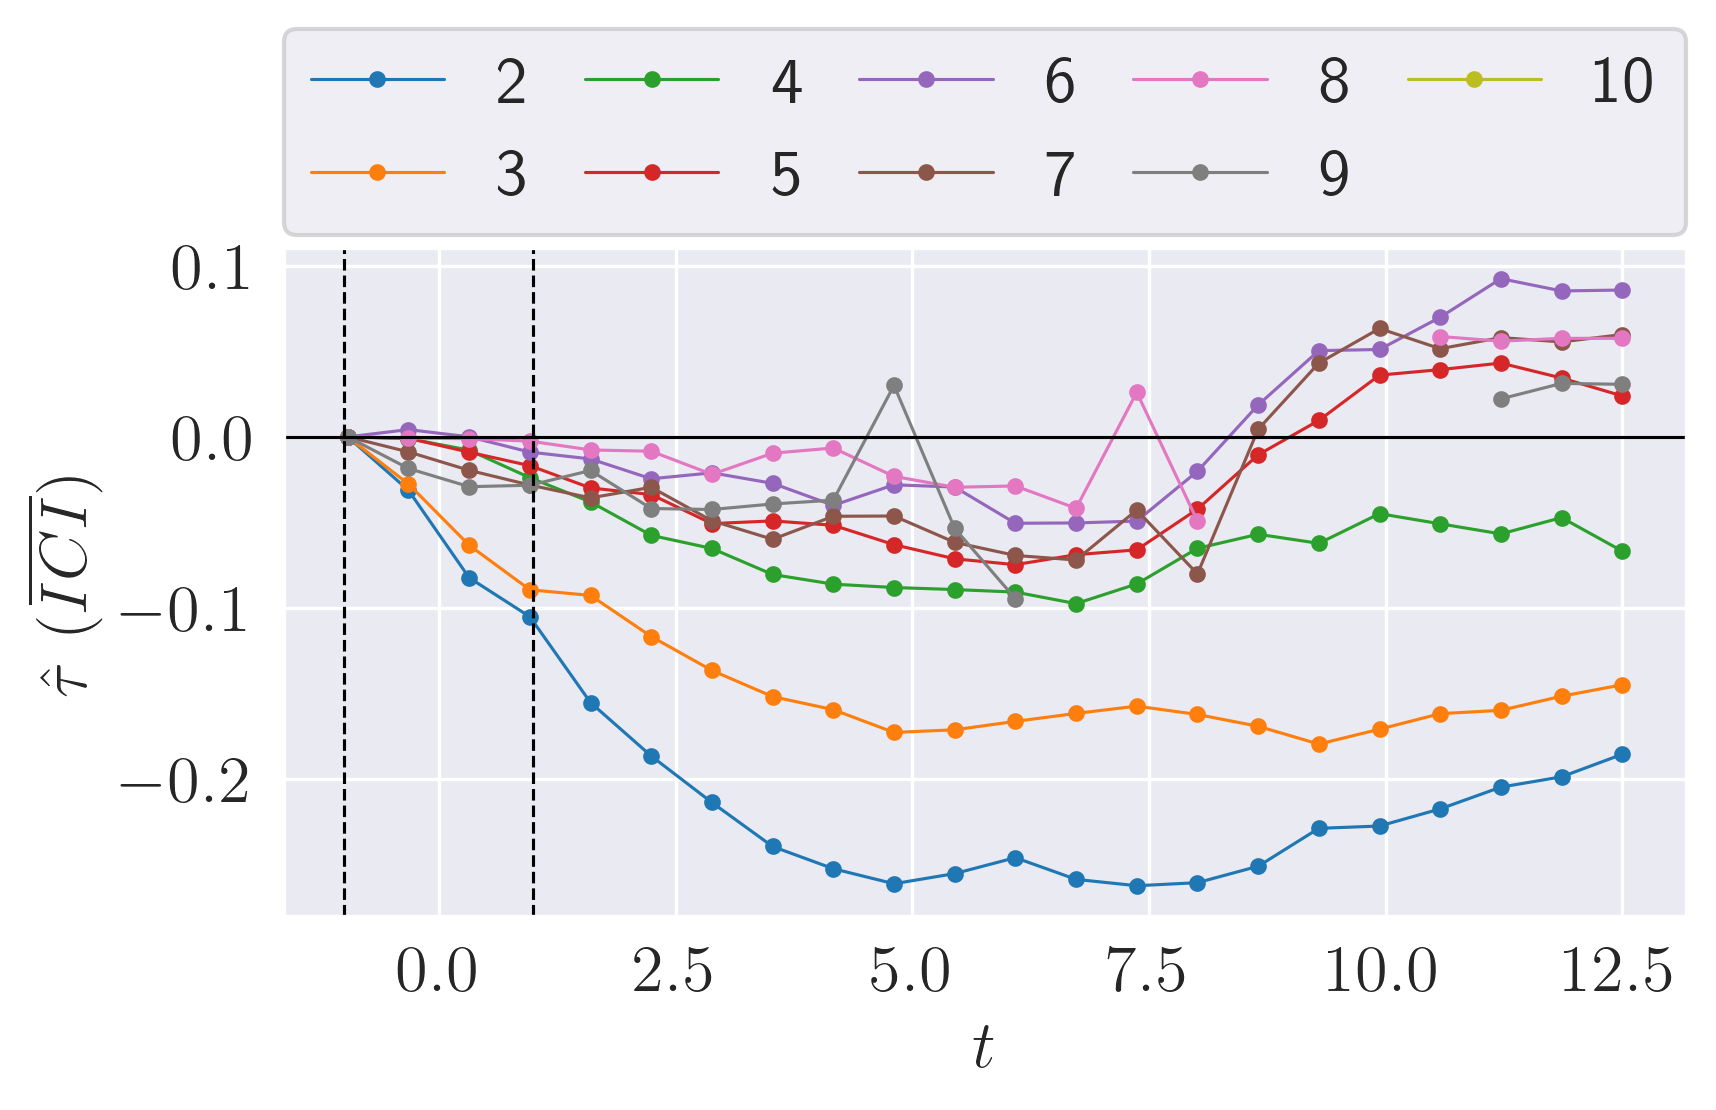

<Figure size 1800x1200 with 0 Axes>

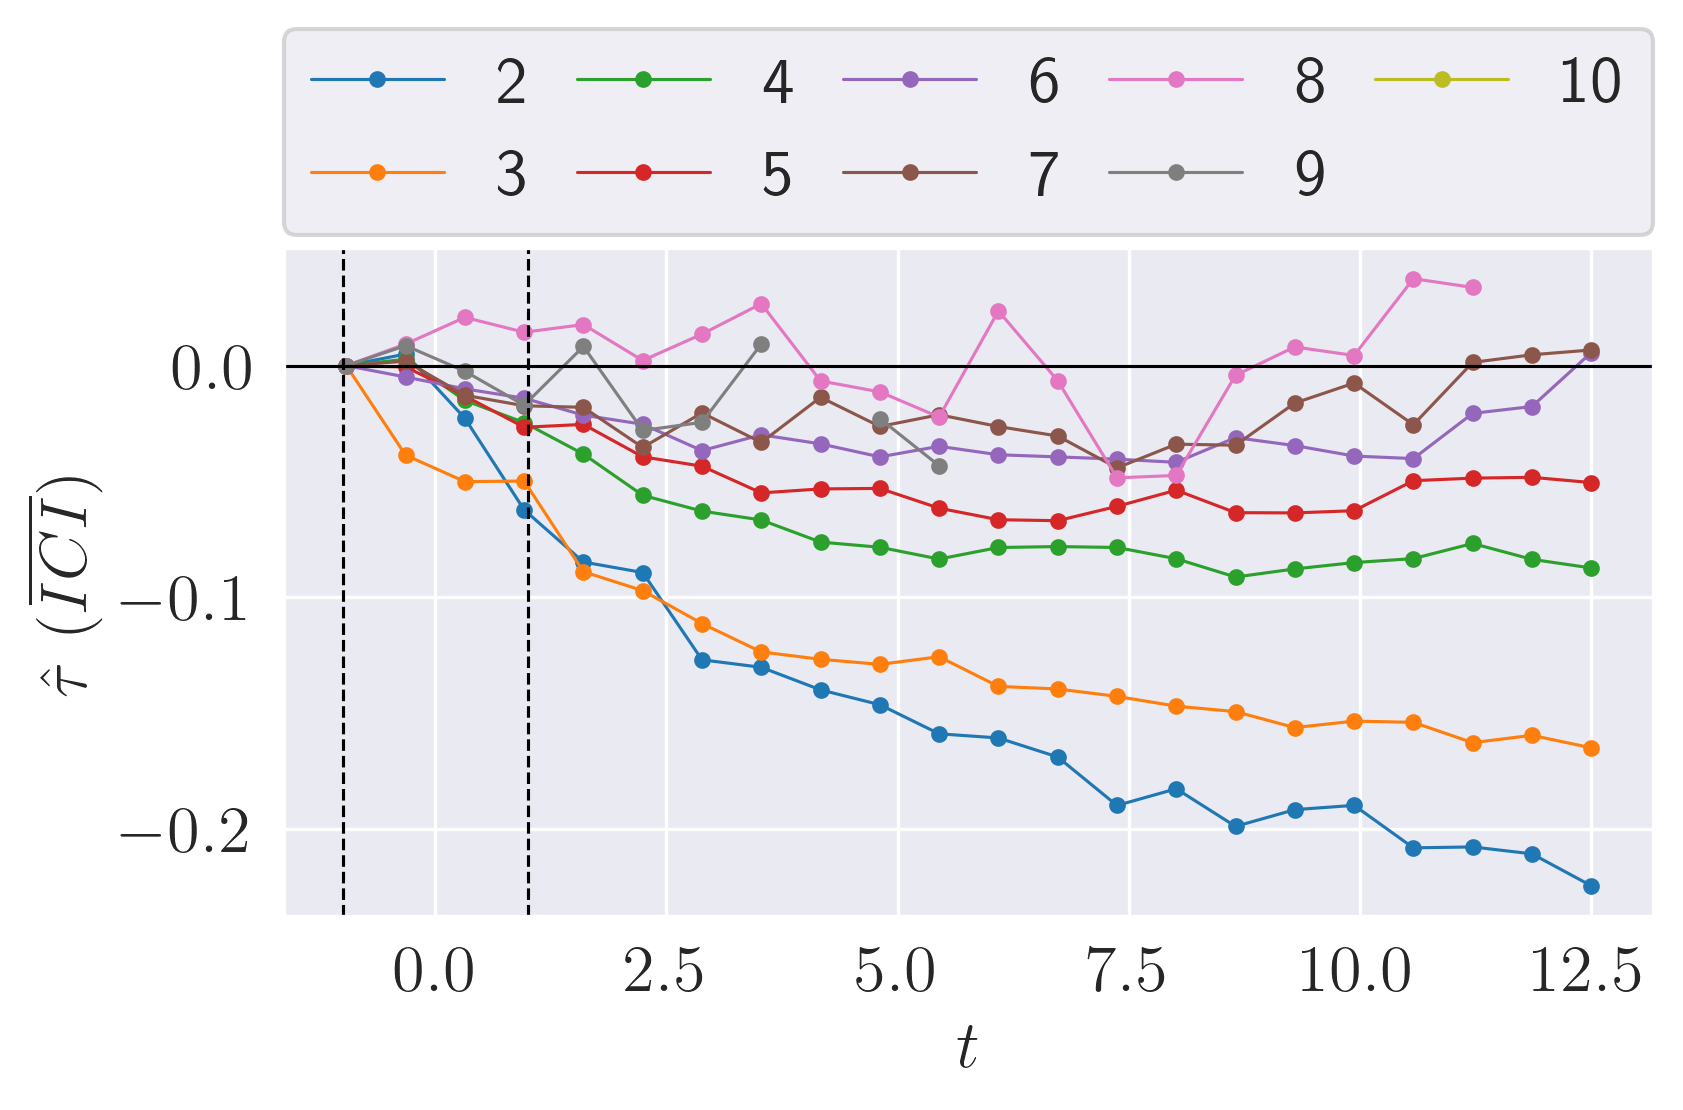

<Figure size 1800x1200 with 0 Axes>

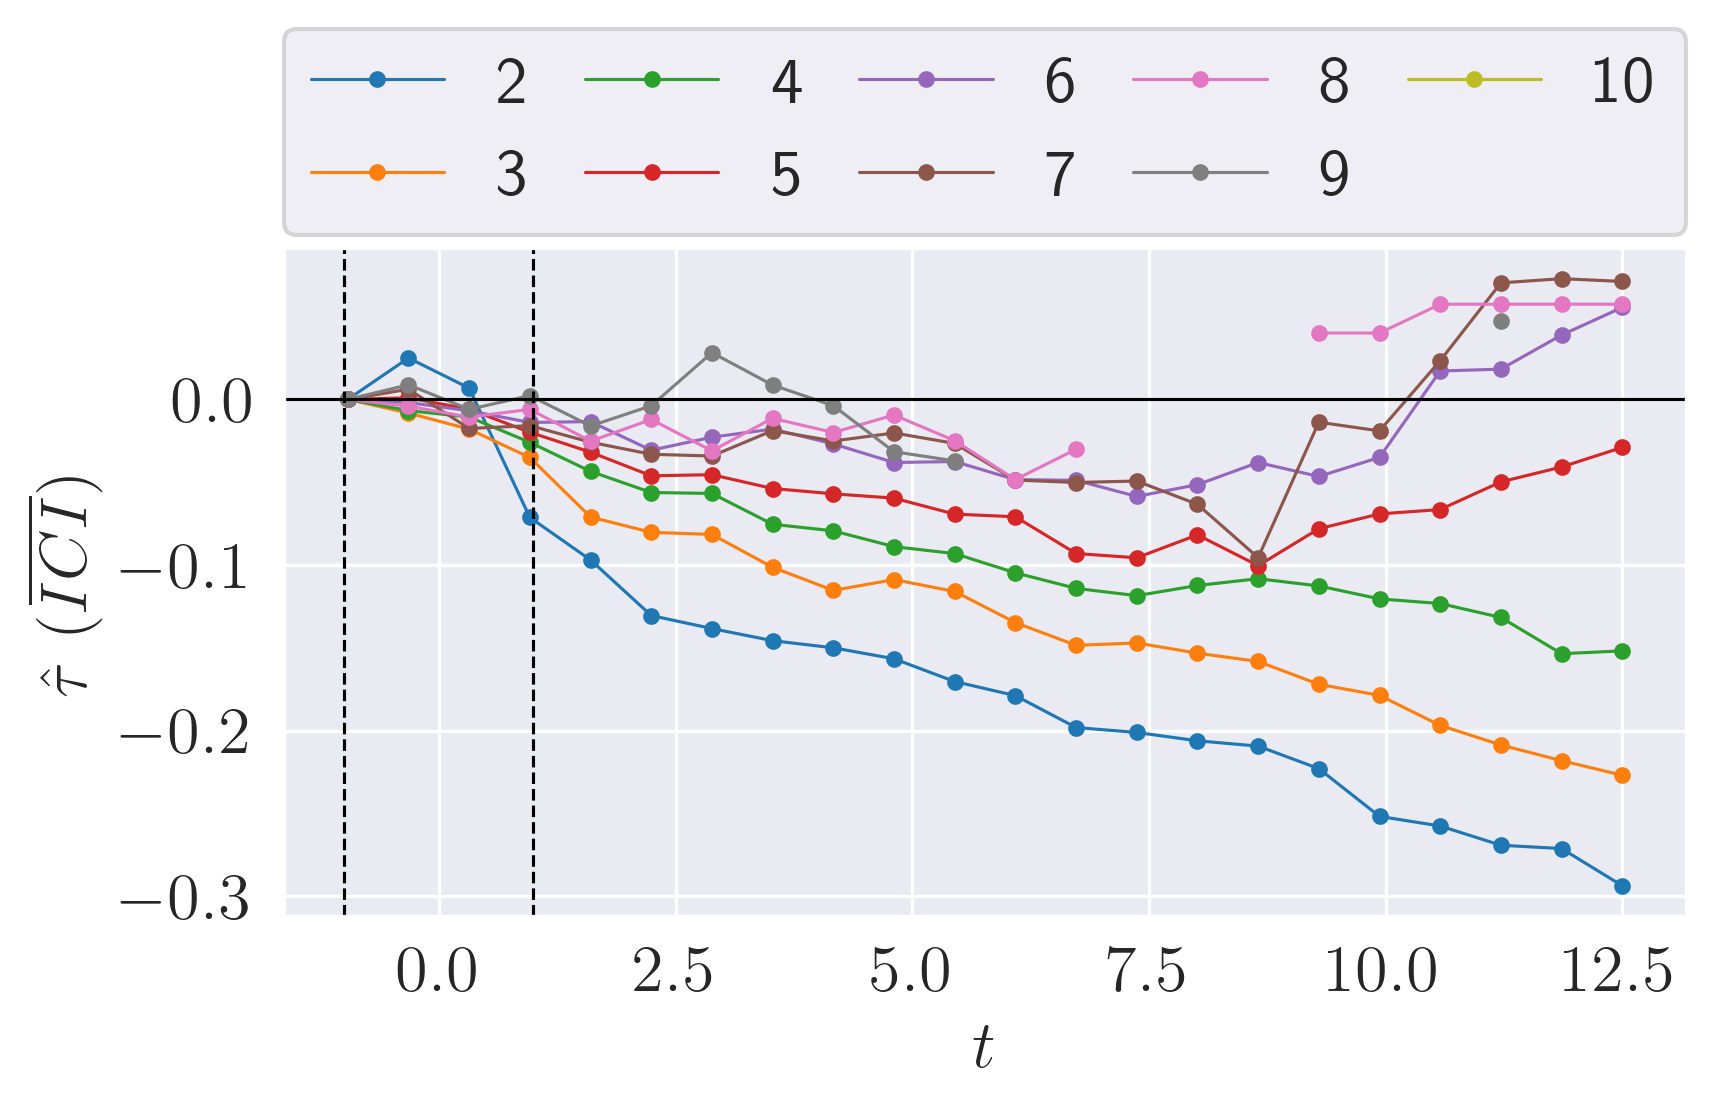

In [13]:
for bit in range(nCat):
    bitmICIs = meanICIs.loc[bit, :]
    df = pd.DataFrame(index=bitmICIs.index, columns=range(max([max(d.keys()) for d in bitmICIs])))
    for ind, val in bitmICIs.iteritems():
        for k, v in val.items():
            df.loc[ind, k] = v / fs

    plt.figure();

    (df.loc[:, 2:10] - df.iloc[0, 2:10]).plot(marker=".", legend=None);
    plt.axhline(0, c='k');
    plt.axvline(-1, ls="--", c='k');
    plt.axvline(1, ls="--", c='k');

    plt.xlabel(r"$t$");
    plt.ylabel(r"$\hat{\tau}~(\widebar{ICI})$");

    plt.legend(
        ncol=5,
        mode="expand",
        bbox_to_anchor=(0., 1.02, 1., .102),
        loc=3,
        borderaxespad=0.,
    );
    plt.tight_layout()




## ICI regularity

In [14]:
def getStdICI(el):
    if el is None:
        return None
    return {k: np.std(np.diff(np.array(v) / fs)) for k, v in el.items()}

In [15]:
stdBaseline = getStdICI(groupedBaseline)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
stdICIs = groupedICI.applymap(getStdICI)

**With regards to -1**

<Figure size 1800x1200 with 0 Axes>

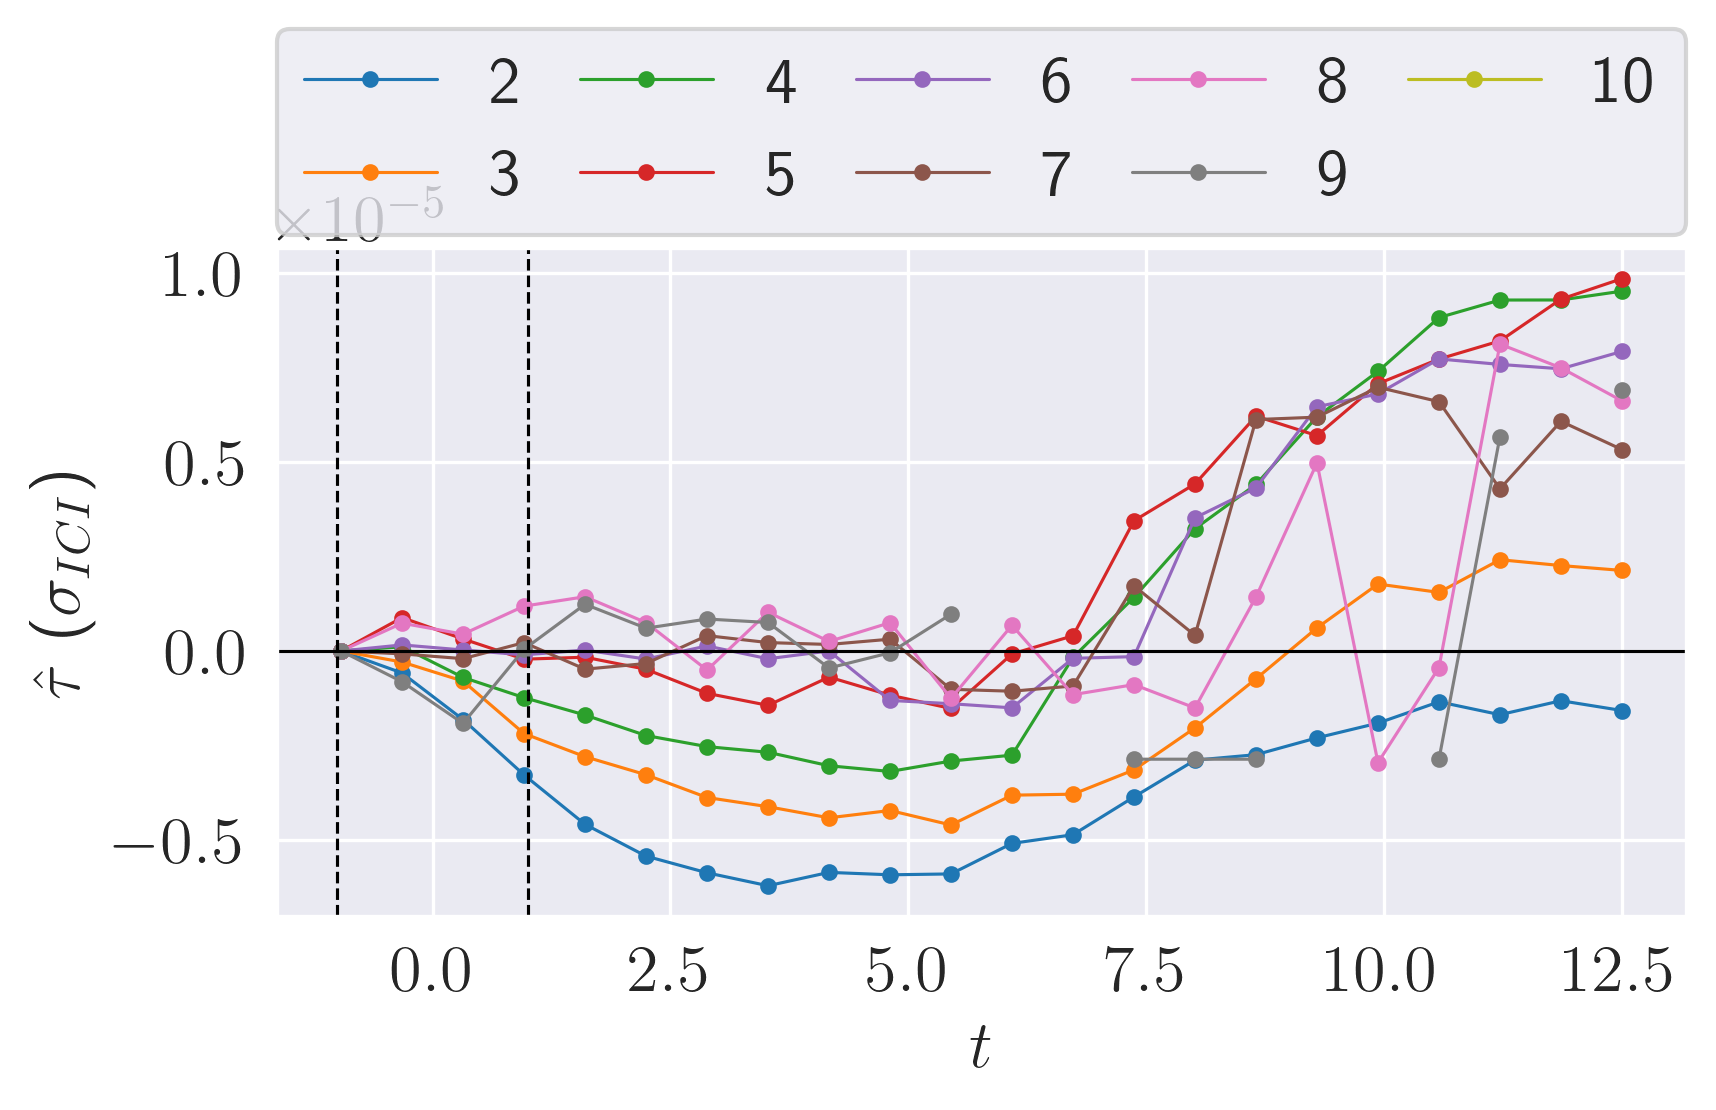

<Figure size 1800x1200 with 0 Axes>

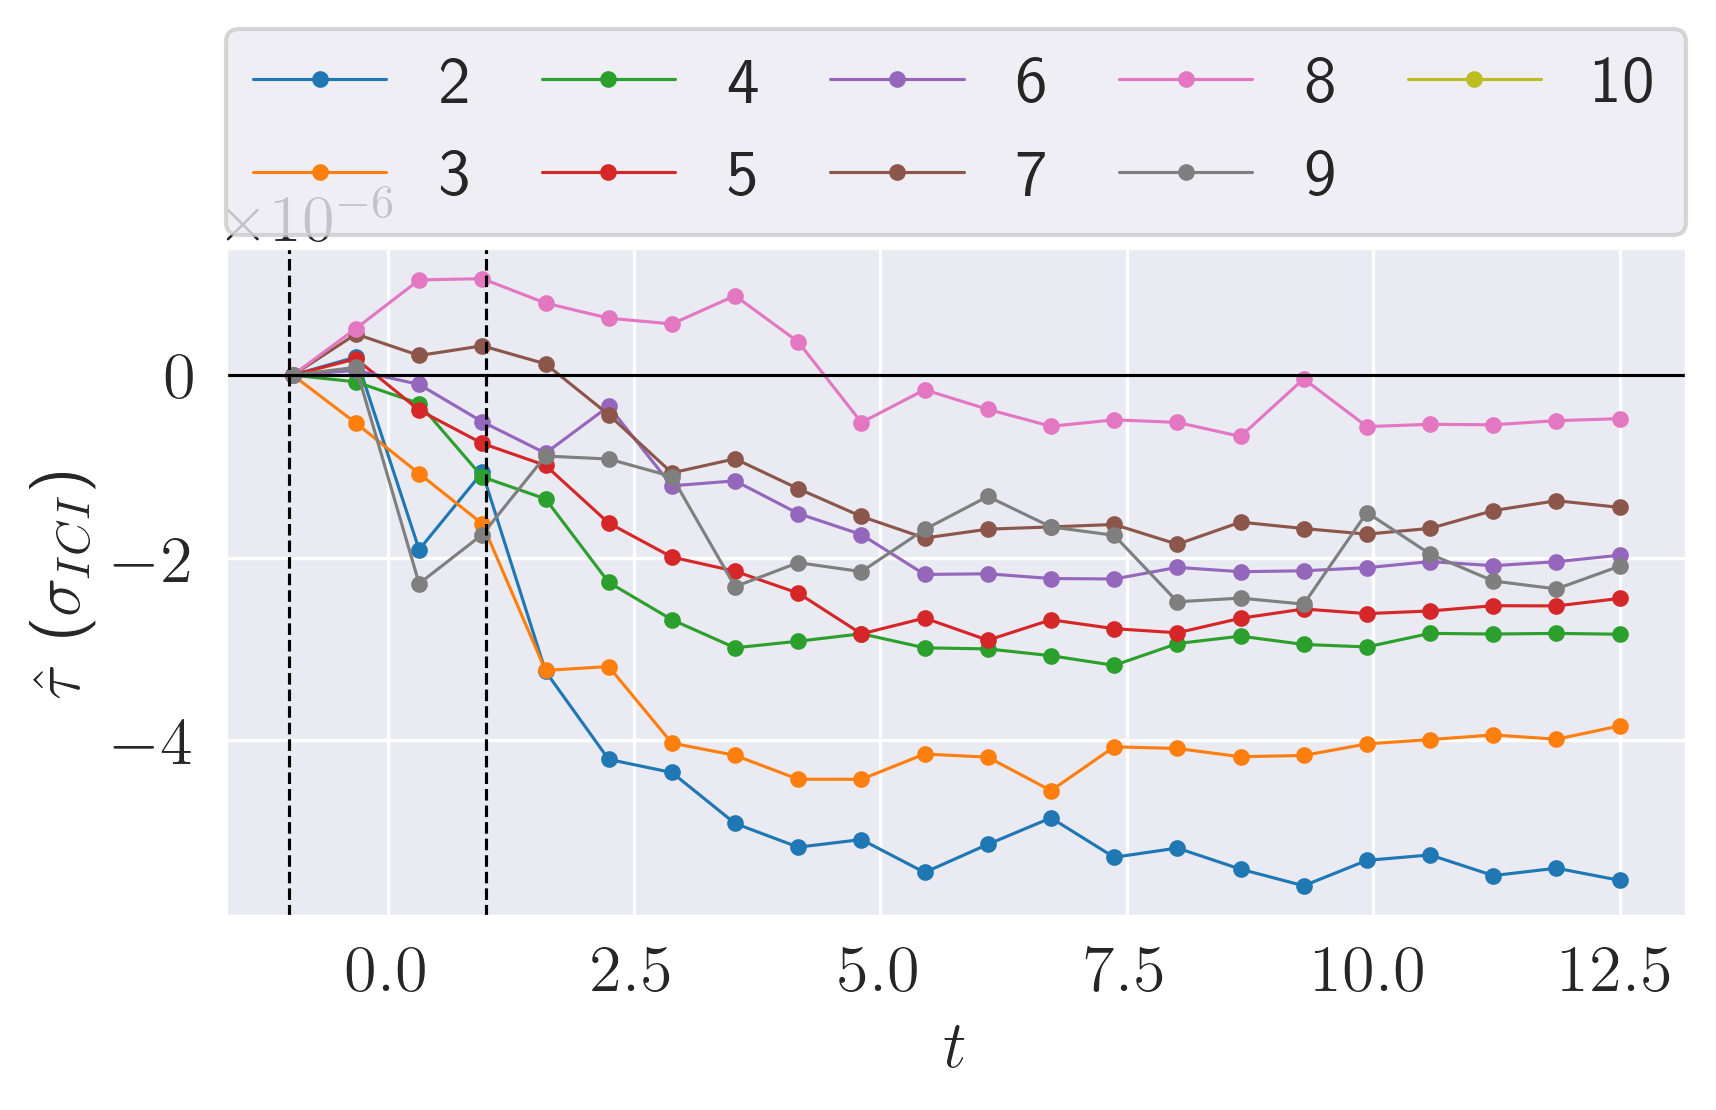

<Figure size 1800x1200 with 0 Axes>

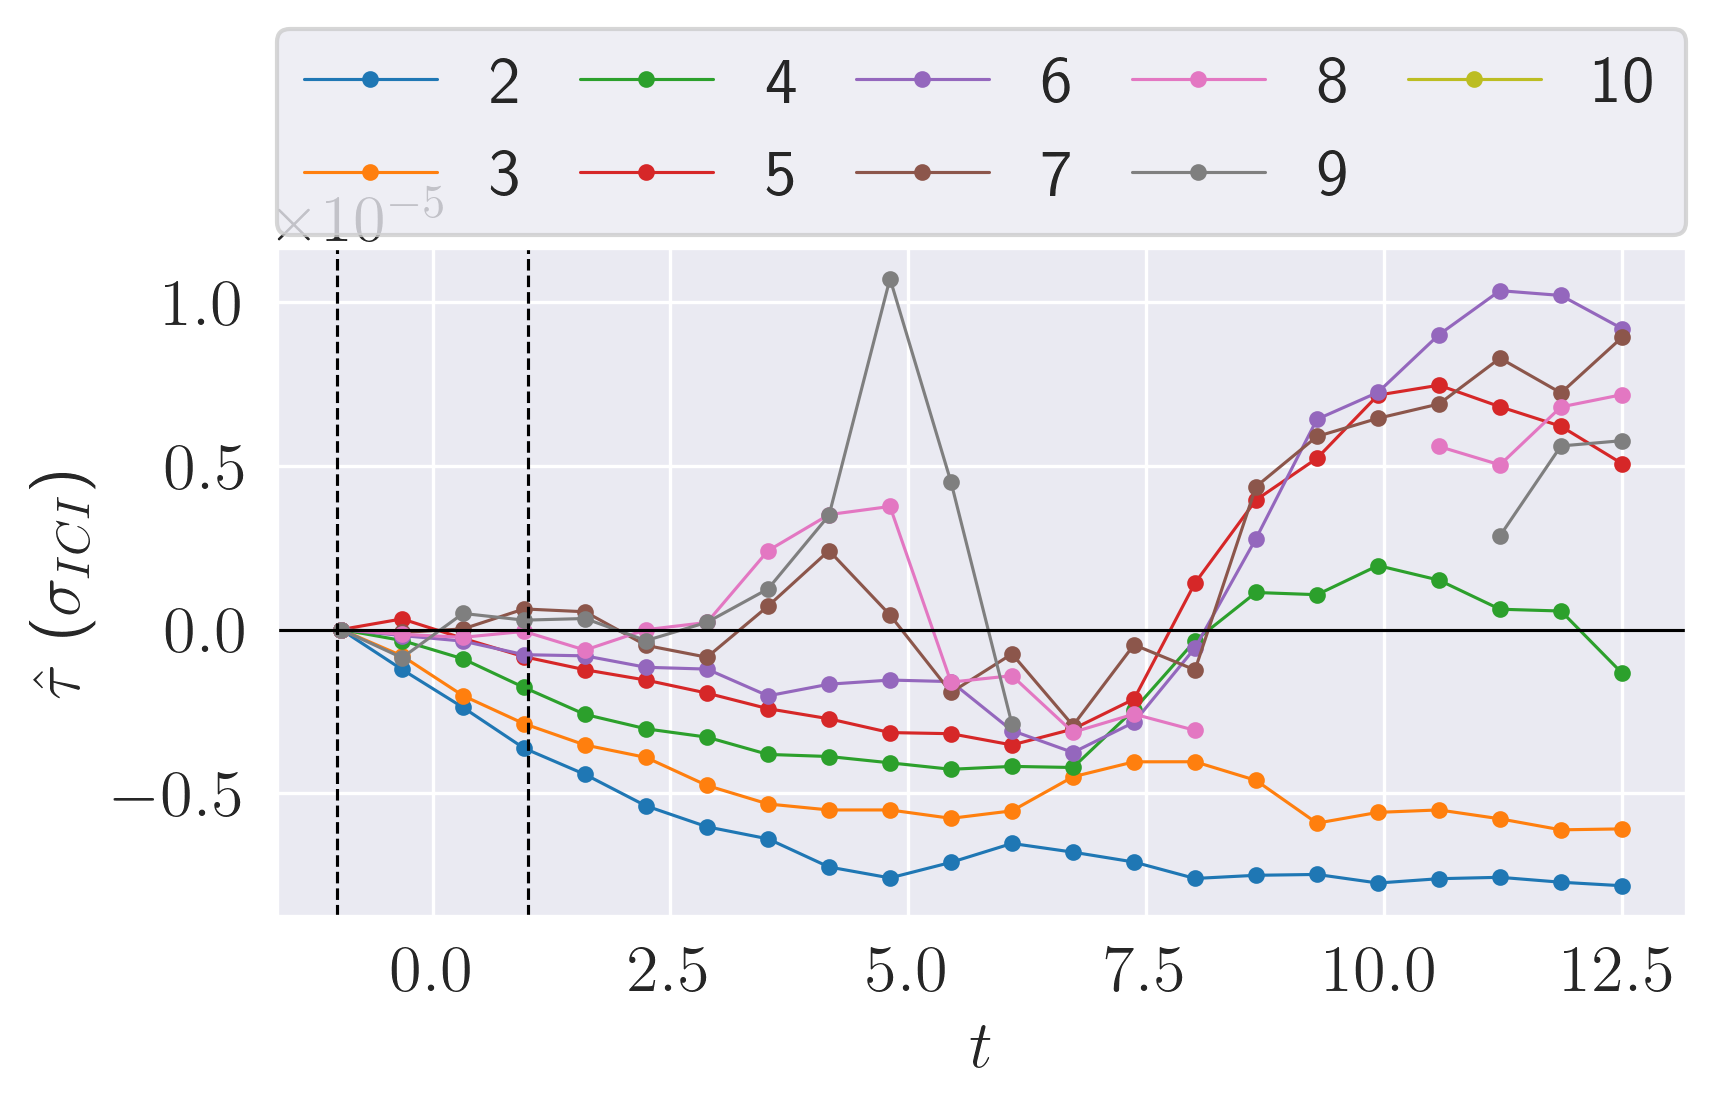

<Figure size 1800x1200 with 0 Axes>

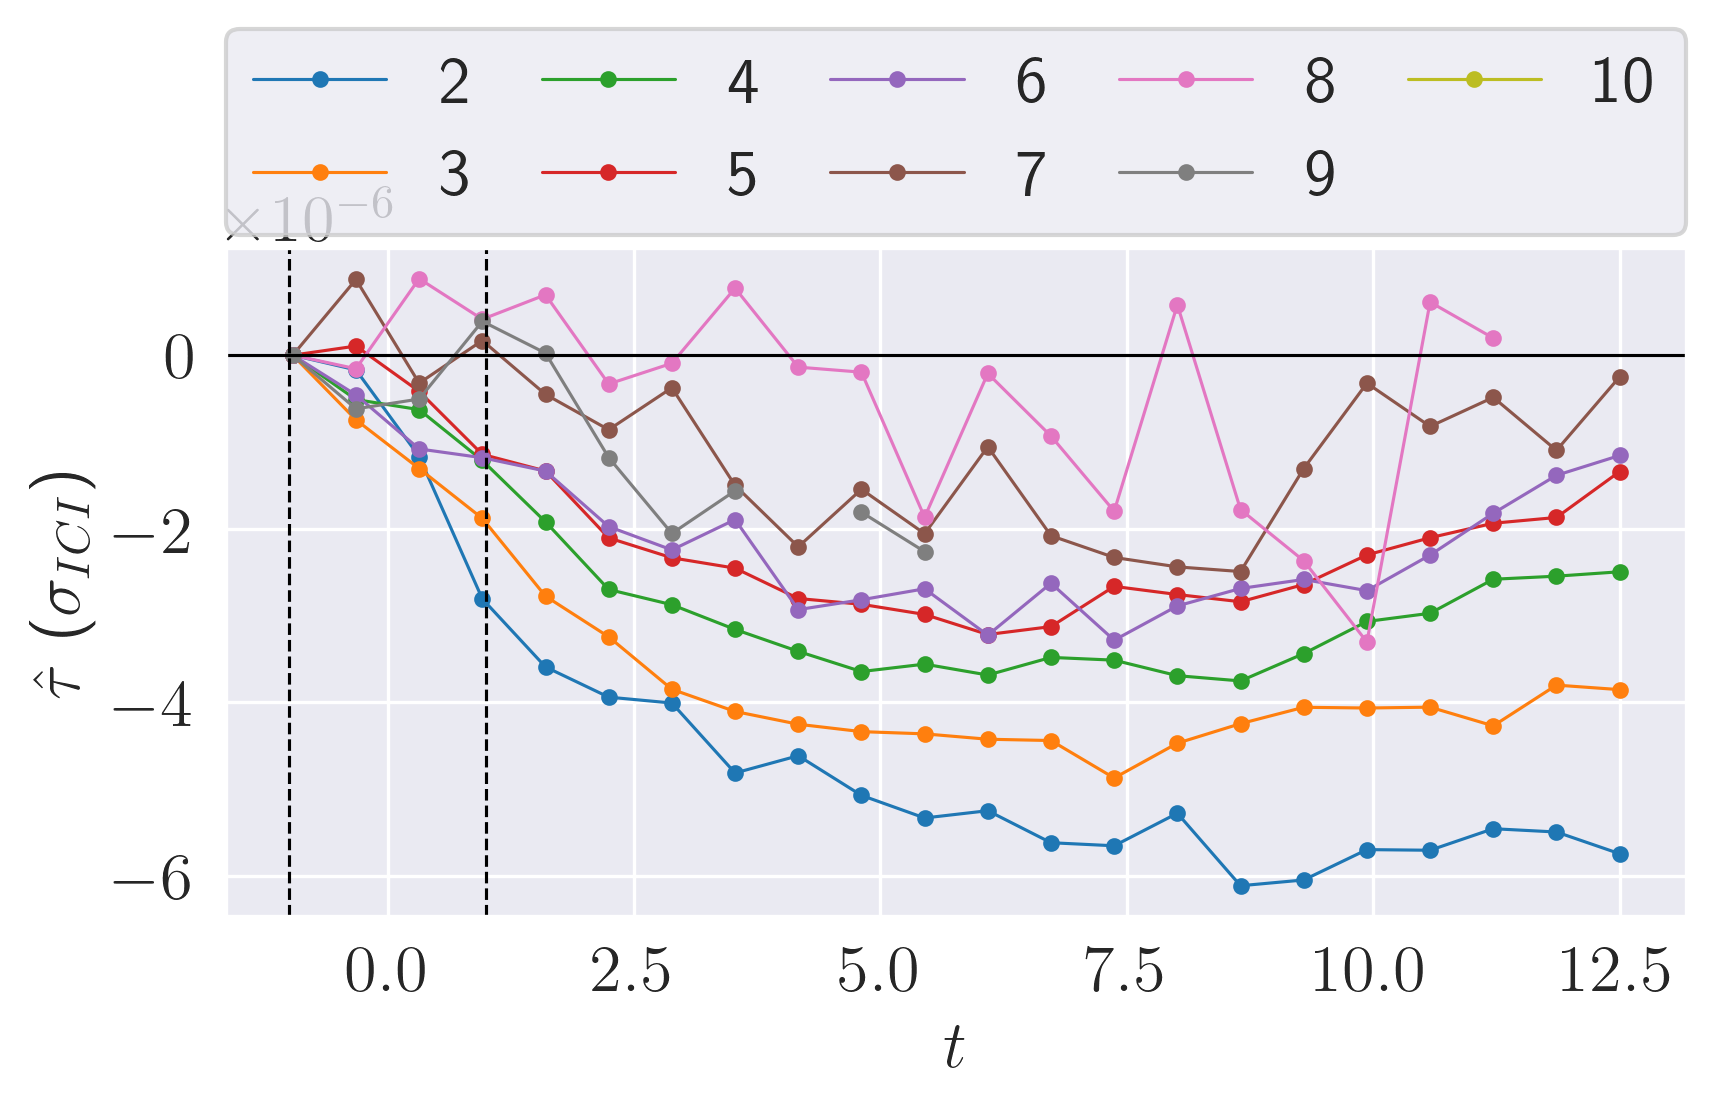

<Figure size 1800x1200 with 0 Axes>

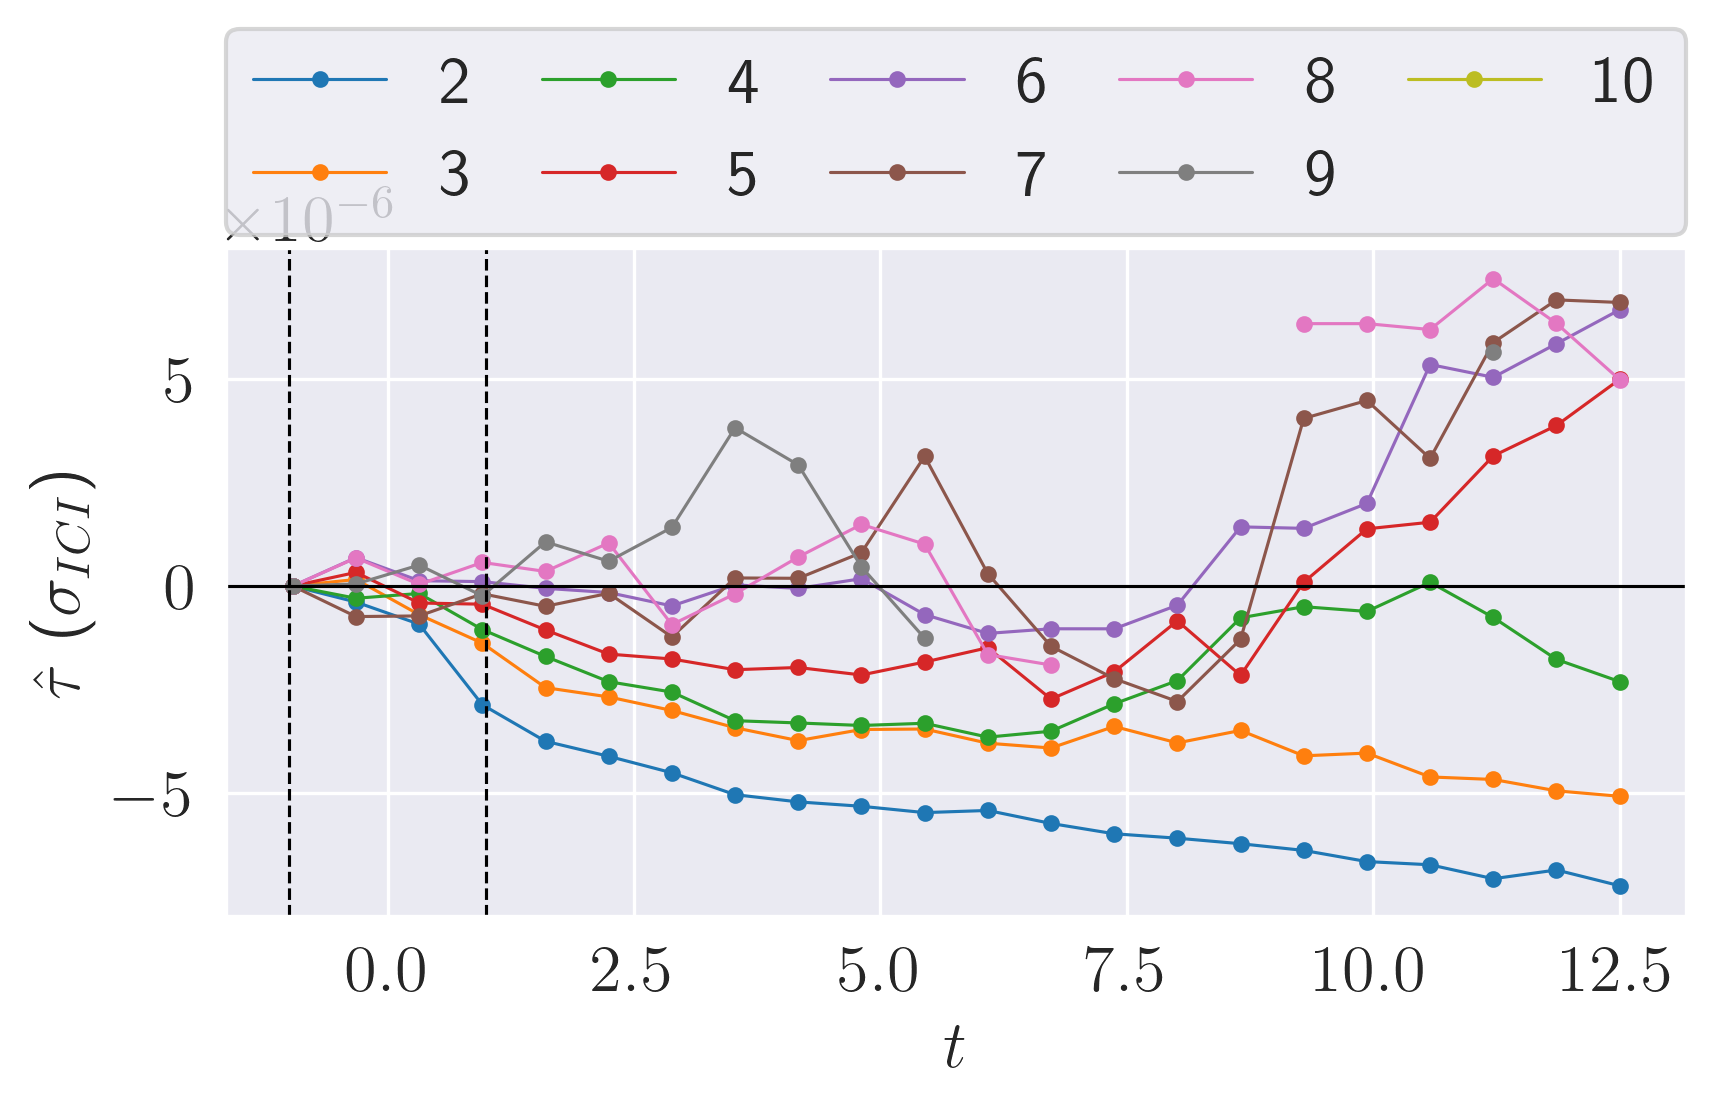

In [18]:
for bit in range(nCat):

    bitstdICIs = stdICIs.loc[bit, :]
    df = pd.DataFrame(index=bitstdICIs.index, columns=range(max([max(d.keys()) for d in bitstdICIs])))
    for ind, val in bitstdICIs.iteritems():
        for k, v in val.items():
            df.loc[ind, k] = v / fs

    plt.figure();

    (df.loc[:, 2:10] - df.iloc[0, 2:10]).plot(marker=".", legend=None);
    plt.axhline(0, c='k');
    plt.axvline(-1, ls="--", c='k');
    plt.axvline(1, ls="--", c='k');

    plt.xlabel(r"$t$");
    plt.ylabel(r"$\hat{\tau} ~\text{(}\sigma_{ICI}\text{)}$");

    plt.legend(
        ncol=5,
        mode="expand",
        bbox_to_anchor=(0., 1.02, 1., .102),
        loc=3,
        borderaxespad=0.,
    );
    plt.tight_layout()


# Incremental causal effect

## Mean

In [23]:
ICEM = np.zeros(shape=(nCat, 10))

ignore missing

In [24]:
dfs = {}

In [25]:
for nClicks in range(2, 12):
    dfs[nClicks] = meanICIs.applymap(lambda x: x[nClicks] / fs if nClicks in x.keys() else None, na_action="ignore", )

In [26]:
for nClicks in dfs.keys():
    ICEM[:, nClicks - 2] = (dfs[nClicks].loc[range(5), :].diff(axis=1)
                            / ((dfs[nClicks].columns[-1] - dfs[nClicks].columns[0]) / (len(dfs[nClicks].columns) - 1)
                               )). \
        mean(axis=1)

In [27]:
ICEMDf = pd.DataFrame(ICEM, index=pd.Index(range(5), name="bit"), columns=pd.Index(range(2, 12), name="nClicks"))

In [29]:
ICEMDf.round(3)

nClicks,2,3,4,5,6,7,8,9,10,11
bit,,,,,,,,,,
0,-0.013,-0.002,0.007,0.007,0.005,0.004,0.004,0.009,0.008,NaN
1,-0.018,-0.011,-0.011,-0.009,-0.007,-0.006,-0.003,-0.003,-0.003,-0.007
2,-0.014,-0.011,-0.005,0.002,0.006,0.004,-0.005,-0.010,-0.027,-0.008
3,-0.017,-0.012,-0.006,-0.004,0.000,0.001,0.003,-0.002,-0.008,NaN
4,-0.022,-0.017,-0.011,-0.002,0.004,0.005,-0.001,-0.006,-0.001,0.000


### The sign score

In [34]:
score = (-1 + 2 * (ICEMDf >= 0)).sum(axis=1)
score

bit
0     4
1   -10
2    -4
3    -4
4    -4
dtype: int64

## Regularity

In [35]:
ICES = np.zeros(shape=(nCat, 10))

In [36]:
dfsS = {}

In [37]:
for nClicks in range(2, 12):
    dfsS[nClicks] = stdICIs.applymap(lambda x: x[nClicks] if nClicks in x.keys() else None, na_action="ignore", )

In [38]:
for nClicks in dfsS.keys():
    ICES[:, nClicks - 2] = (dfsS[nClicks].loc[range(5), :].diff(axis=1)
                            / ((dfsS[nClicks].columns[-1] - dfsS[nClicks].columns[0]) /
                               (len(dfsS[nClicks].columns) - 1))). \
        mean(axis=1)

In [39]:
ICESDf = pd.DataFrame(ICES, index=pd.Index(range(5), name="bit"),
                      columns=pd.Index(range(2, 12), name="nClicks"))

In [40]:
ICESDf.round(3)

nClicks,2,3,4,5,6,7,8,9,10,11
bit,,,,,,,,,,
0,-0.004,0.005,0.023,0.023,0.019,0.013,0.016,0.037,0.019,NaN
1,-0.013,-0.009,-0.007,-0.006,-0.005,-0.003,-0.001,-0.005,-0.007,-0.005
2,-0.019,-0.014,-0.003,0.012,0.022,0.021,-0.004,0.000,-0.072,-0.074
3,-0.014,-0.009,-0.006,-0.003,-0.003,-0.001,0.001,-0.013,-0.004,NaN
4,-0.017,-0.012,-0.005,0.012,0.016,0.016,-0.010,-0.006,-0.014,0.015


### The sign score

In [41]:
score = (-1 + 2 * (ICESDf >= 0)).sum(axis=1)
score


bit
0     6
1   -10
2    -2
3    -8
4    -2
dtype: int64